# Circulos de Mohr y circulo de tracciones

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook se puede ejecutar interactivamente en [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/mohr_circles.ipynb).

Visualización del círculo de tracciones gracias al paquete **continuum_mechanics** V0.2.2 [(Guarín-Zapata et al.,2021)](https://doi.org/10.5281/zenodo.4682112)

## Required modules

In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    try:
        import continuum_mechanics
    except ImportError as e:
        %pip install continuum_mechanics
    # %pip install matplotlib==3.6.0
else:
    print('Not running on CoLab. Install the required modules manually in your local environment.')

Not running on CoLab. Install the required modules manually in your local environment.


In [2]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, widgets, fixed
from continuum_mechanics.visualization import mohr2d, mohr3d, traction_circle

## Global configuration for plots

In [3]:
plt.style.use("default")
mpl.rcParams.update(
    {
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)


**Centro, $c$, y esfuerzo medio, $\sigma_\mathrm{m}$**
$$
c = \sigma_\mathrm{m} = \frac{1}{2} (\sigma_\mathrm{xx} + \sigma_\mathrm{yy})
$$

**Radio, $r$ y esfuerzo cortante máximo, $\tau_\mathrm{max}$**

$$
r = \tau_\mathrm{max} = \sqrt{\tau_\mathrm{xy} + (\sigma_\mathrm{xx}^2 - c)^2}
$$

## Funciones

In [4]:
def plot_mohr_circle(
    sigma_xx, sigma_yy, tau_xy, plot_envelope=False, envelope={'c': 5, 'ϕ': 27},
     plot_pole=False, plot_plane=False, alpha=0, xlim=None, ylim=None
):
    if type(envelope) == str:  # This is for interpreting in from the widget
        envelope = ast.literal_eval('{' + envelope + '}')

    c = 0.5 * (sigma_xx + sigma_yy)
    r = np.sqrt((sigma_xx - c) ** 2 + tau_xy**2)
    sig_1 = r * np.cos(0) + c
    sig_3 = r * np.cos(np.pi) + c

    outcome = {
        "sig_1": sig_1,
        "sig_3": sig_3,
        "sig_xx": sigma_xx,
        "sig_yy": sigma_yy,
        "tau_xy": tau_xy,
        "s": 0.5 * (sig_1 + sig_3),
        "t": 0.5 * (sig_1 - sig_3),
        "p": 1 / 3 * (sig_1 + 2 * sig_3),
        "q": sig_1 - sig_3,
    }

    theta = np.linspace(0, 2 * np.pi, 200)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[7, 4.5])
    ax.axhline(y=0, c="k")
    ax.plot(r * np.cos(theta) + c, r * np.sin(theta), c="k")  # Mohr circle

    label = "$\sigma_{1}=$" + f"{sig_1:.1f}"  # sigma_1
    ax.plot(sig_1, 0, ls="", c="#BB5566", marker=".", ms=12, label=label)
    label = "$\sigma_{3}=$" + f"{sig_3:.1f}"  # sigma_3
    ax.plot(sig_3, 0, ls="", c="#004488", marker=".", ms=12, label=label)
    # Mean stress
    ax.plot(c, 0, ls="", c="k", marker="o", label="$\sigma_\mathrm{m}=$" + f"{c:.1f}")
    label = "$\\tau_\mathrm{max}=$" + f"{r:.1f}"  # tau_max
    ax.plot(c, r, ls="", c="orchid", marker="o", ms=7, label=label)
    # sigma_xx, tau_xy
    label = ("$\sigma_{xx}=$" + f"{sigma_xx:.1f}" + ",\n$\\tau_{xy}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_xx, tau_xy, ls="", c="#DDAA33", marker="s", label=label)
    # sigma_yy, (-)tau_xy
    label = ("$\sigma_{yy}=$" + f"{sigma_yy:.1f}" + ",\n$\\tau_{yx}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_yy, -1 * tau_xy, ls="", c="#117733", marker="s", label=label)

    pole = (sigma_xx, -1 * tau_xy)
    if plot_pole:  # Pole and stress on a plane
        ax.axhline(y=pole[1], c="k", ls="--", lw=0.75)
        ax.axvline(x=pole[0], c="k", ls="--", lw=0.75)
        ax.plot(*pole, ls="", c="k", marker="o", fillstyle='none', label=f"Pole: {pole}")
    if  plot_plane:
        # beta = 0.5 * np.degrees(np.arctan(tau_xy/sigma_xx))
        # beta = np.degrees(np.arctan((sig_1 - sigma_xx)/tau_xy))
        beta = 0.5 * np.degrees(np.arctan2(2 * tau_xy, sigma_xx - sigma_yy))
        theta = alpha + beta
        plane_sig_n = r * np.cos(np.radians(2 * theta)) + c
        plane_tau_n = r * np.sin(np.radians(2 * theta))
        label = (
            "Stress state on the plane\n" + "$\sigma_\mathrm{n}=$" + f"{plane_sig_n:.1f}"
            + ", $\\tau_\mathrm{n}=$" + f"{plane_tau_n:.1f}"
        )
        ax.plot(plane_sig_n, plane_tau_n, ls="", c="r", marker=".", label=label)
        ax.plot(
            (plane_sig_n, pole[0]), (plane_tau_n, pole[1]), c="r", ls="--",
            lw=0.75, label=f"Plane at {alpha:.1f}" + "$^{\circ}\circlearrowleft$ from $y^{(+)}$"
        )
        ax.plot(
            (plane_sig_n, c), (plane_tau_n, 0), c="b", ls="--",
            lw=0.75, label="2$\\theta=$" + f"{theta:.1f}" + "$^{\circ}$"
        )

    if plot_envelope:  # Failure envelope
        tan_ϕ = np.tan(np.radians(envelope['ϕ']))
        c_env = envelope['c']
        label = ("Failure criterion \n $\\tau_\mathrm{n} = "+ f"{c_env} + "
                 + "\\tan" + f"{envelope['ϕ']}^\circ" + "\sigma_\mathrm{n}$")
        # ax.axline(xy1=(0, c_env), slope=np.tan(ϕ_r), c="r", label=label)
        xlim = ax.get_xlim() if xlim is None else xlim
        ylim = ax.get_ylim() if ylim is None else ylim
        x_env = np.array([-9e9, 9e9])
        ax.plot(x_env, tan_ϕ * x_env + c_env, c="r", label=label)

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    # # ax.axis("equal")
    # ax.set_aspect("equal", adjustable=None, anchor='C')
    ax.set_aspect("equal", anchor=None)
    ax.set(
        xlabel="Normal stress, $\sigma_\mathrm{n}$",
        ylabel="Shear stress, $\\tau_\mathrm{n}$",
        xlim=xlim,
        ylim=ylim
    )
    fig.tight_layout()
    return outcome

def plot_traction_circle(sigma_xx, sigma_yy, tau_xy):
    array = np.array([[sigma_xx, tau_xy], [tau_xy, sigma_yy]])
    ax = traction_circle(array)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    return


## Herramienta 1: Círculo de Mohr

In [5]:
# Imagen interactiva
style = {'description_width': '100px'}
interact(  # Interactive widgets
    plot_mohr_circle,
    sigma_xx=widgets.FloatSlider(value=30, min=0, max=100, description="σ_xx", style=style),
    sigma_yy=widgets.FloatSlider(value=20, min=0, max=100, description="σ_yy", style=style),
    tau_xy=widgets.FloatSlider(value=10, min=-25, max=25, description="𝜏_xy", style=style),
    plot_envelope=widgets.Checkbox(value=False, description="Plot envelope?", style=style),
    envelope=widgets.Text(value="'c': 5, 'ϕ': 27", description="Parameters: ", style=style),
    plot_pole=widgets.Checkbox(value=False, description="Plot pole?", style=style),
    plot_plane=widgets.Checkbox(value=False, description="Plot a plane?", style=style),
    alpha=widgets.FloatSlider(value=0, min=0, max=180, step=0.2, description="α", style=style),
    xlim=widgets.FloatRangeSlider(value=[10, 40], min=-50, max=100, step=.5, description='x-axis:', readout_format='.0f'),
    ylim=widgets.FloatRangeSlider(value=[-15, 15], min=-100, max=100, step=.5, description='y-axis:', readout_format='.0f'),
)

interactive(children=(FloatSlider(value=30.0, description='σ_xx', style=SliderStyle(description_width='100px')…

<function __main__.plot_mohr_circle(sigma_xx, sigma_yy, tau_xy, plot_envelope=False, envelope={'c': 5, 'ϕ': 27}, plot_pole=False, plot_plane=False, alpha=0, xlim=None, ylim=None)>

{'sig_1': 36.180339887498945,
 'sig_3': 13.819660112501051,
 'sig_xx': 30,
 'sig_yy': 20,
 'tau_xy': 10,
 's': 25.0,
 't': 11.180339887498947,
 'p': 21.273220037500348,
 'q': 22.360679774997894}

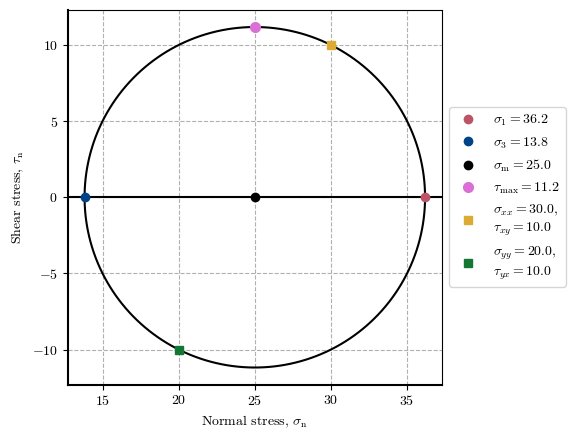

In [6]:
# Imagen no interactiva
plot_mohr_circle(sigma_xx=30, sigma_yy=20, tau_xy=10)

## Herramienta 2: Círculo de tracciones

In [7]:
# Imagen interactiva
style = {'description_width': '100px'}
interact(  # Interactive widgets
    plot_traction_circle,
    sigma_xx=widgets.FloatSlider(value=10, min=-100, max=100, description="σ_xx", style=style),
    sigma_yy=widgets.FloatSlider(value=5, min=-100, max=100, description="σ_yy", style=style),
    tau_xy=widgets.FloatSlider(value=1, min=-100, max=100, description="𝜏_xy", style=style),
)

interactive(children=(FloatSlider(value=10.0, description='σ_xx', min=-100.0, style=SliderStyle(description_wi…

<function __main__.plot_traction_circle(sigma_xx, sigma_yy, tau_xy)>

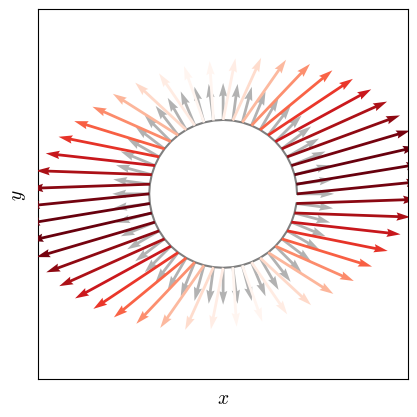

In [8]:
# Imagen no interactiva
plot_traction_circle(sigma_xx=10, sigma_yy=5, tau_xy=1)